# Classification Models Performance Comparison using Adult Income Dataset
We previously carried out an exploratory data analysis on the Adult income dataset. This can be forund <b>[Here](https://github.com/osareniho-oni/exploratory-data-analysis)</b>

In this tutorial we shall build and evaluate different models using the dataset. 

After this tutorial, you will know:
- How to wrangle a dataset using a python function
- How to preprocess categorical and numerical features using OneHotEncoder and StandardScalar respectively
- How to build, evaluate and compare performance of classification models before choosing the best for your data.

### What is Binary Classification?
Binary classification is a supervised learning algorithm in machine learning that categorizes new observations into one of two classes. It is a fundamental task in machine learning where the goal is to predict which of two possible classes an instance of data belongs to. It involves categorizing data into two distinct groups based on specific criteria, a process akin to making a ‘yes or no’ decision.ses.

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

## PREPARE DATA

### Explore Dataset

In [2]:
df = pd.read_csv("data/adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# Check shape of dataset
df.shape

(48842, 15)

The DataFrame has 48842 rows and 15 columns

In [4]:
#Get summary of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


No column has null values

In [5]:
# Get value count of income column
df["income"].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [6]:
df["income"].value_counts(normalize=True)

income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64

37155 (76%) Adults earn <=50K while 11687 (24%) Adults earn >50K

### Load Data

### Create a wrangle function to:
 - import data
 - drop rows with missing values
 - Encode target variable (0 for the majority class and 1 for the minority class as is the custom for imbalance binary classification dataset)

In [7]:
def wrangle(filepath):
    # load dataset into a dataframe
    df = pd.read_csv(filepath)
   
    # drop rows with missing values (In this case, columns with '?' values)
    df = df.replace({'?': np.nan}).dropna()
    
    # Binary Encode target variables
    df["income"] = df["income"].map({'<=50K' : 0, '>50K' : 1})
    return df
    

In [8]:
df_income = wrangle("data/adult.csv")
df_income.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,1
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,0


In [9]:
df_income.shape

(45222, 15)

In [10]:
df_income["income"].value_counts()

income
0    34014
1    11208
Name: count, dtype: int64

In [11]:
df_income["income"].value_counts(normalize=True)

income
0    0.752156
1    0.247844
Name: proportion, dtype: float64

## BUILD MODEL

### Split into Training set and test set

In [12]:
# feature columns
X = df_income.drop(columns=["income"])

# target column
y = df_income["income"]
print(X.shape, y.shape)

(45222, 14) (45222,)


In [62]:
# Split the data into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36177, 14) (9045, 14) (36177,) (9045,)


### Baseline Model

In [14]:
# Determine the majority class 
majority_class = Counter(y_train).most_common(1)[0][0]
# Predict the majority class for all instances in the test set
y_test_pred_majority = [majority_class] * len(y_test)
# Calculate accuracy
accuracy_score_majority = accuracy_score(y_test, y_test_pred_majority)
print(f"Base Model (Majority Voting) Accuracy on Test Set: {accuracy_score_majority}")

Base Model (Majority Voting) Accuracy on Test Set: 0.756440022111664


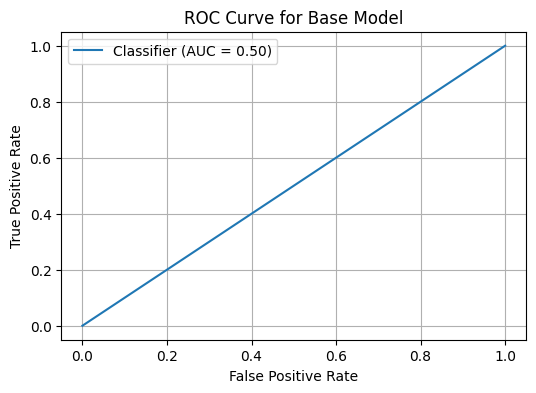

In [15]:
# Plot ROC curves
fig, ax = plt.subplots(figsize = (6, 4))

# Plot ROC curve for no sampling (original data)
RocCurveDisplay.from_predictions(y_test, y_test_pred_majority, ax=ax)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Base Model')
plt.legend()
plt.grid(True)
plt.show()

### Data Preprocessing
- we will scale the numeric features using StandardScalar
- We will encode the categorical features using OneHotEncoder
- Then create separate pipelines for processing the categorical and numeric features

In [16]:
# Select Categorical columns in training set
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Select Numerical columns in training set
numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['int64']]

# Create transformers for numeric and categorical features
numeric_transformer = make_pipeline(
    StandardScaler()
)

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

# Combine transformers for both types of features using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline
pipeline = make_pipeline(preprocessor)

### Train and Evaluate Model

In [17]:
# Define binary classification algorithms
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}


In [18]:
# Create funtion for classification models evaluation

def evaluate_classification_models(models, preprocessor, X_train, y_train, X_test, y_test):
    results = {}
    predictions = {}
    for model_name, model in models.items():
        # Create pipeline with preprocessing and classification model
        clf_model = make_pipeline(preprocessor, model)
        
        # Fit the pipeline to the training data
        clf_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = clf_model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store the accuracy in the results dictionary
        results[model_name] = accuracy

        # Store y_pred values for each model
        predictions[model_name] = y_pred
        
    return results, predictions



In [19]:
results, predictions = evaluate_classification_models(models, preprocessor, X_train, y_train, X_test, y_test)
print("Classification Accuracy of Each Model:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")

Classification Accuracy of Each Model:
Logistic Regression: 0.8519
Support Vector Machine: 0.8601
Random Forest: 0.8540
Bagging Classifier: 0.8470
Decision Tree: 0.8151
Gradient Boosting: 0.8689


All the algorithms above achieved a classification accuracy above the base accuracy of 0.7564, with Gradient Boosting Algorithm having the highest Accuracy Score

### AUC Score and ROC Curve for the models

In [20]:
def plot_roc_curves_for_models(predictions):
    # Create a single figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))  
    
    for model_name, y_pred in predictions.items():
        # Plot ROC curve for each model
        RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax, name=model_name)

    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


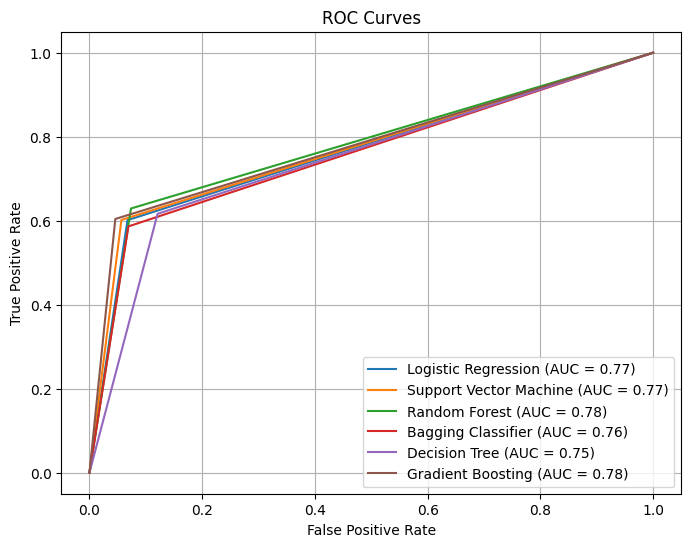

In [21]:
plot_roc_curves_for_models(predictions)

We can see that Random Forest and Gradient Boosting algorithms have the best AUC score

### Confusion Matrix for the models

In [52]:
def plot_confusion_matrix_for_models(predictions):
    num_models = len(predictions)
    # Create a single figure and axes
    fig, axs = plt.subplots(1, num_models, figsize=(5 * num_models, 6))  

    # Create subplots in a single row
    for i, (model_name, y_pred) in enumerate(predictions.items()):
        
        # Plot confusion matrix for each model
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axs[i])
        axs[i].set_title(f'Confusion Matrix - {model_name}')

        # Adjust layout to prevent overlap
        plt.tight_layout()
    plt.show();    

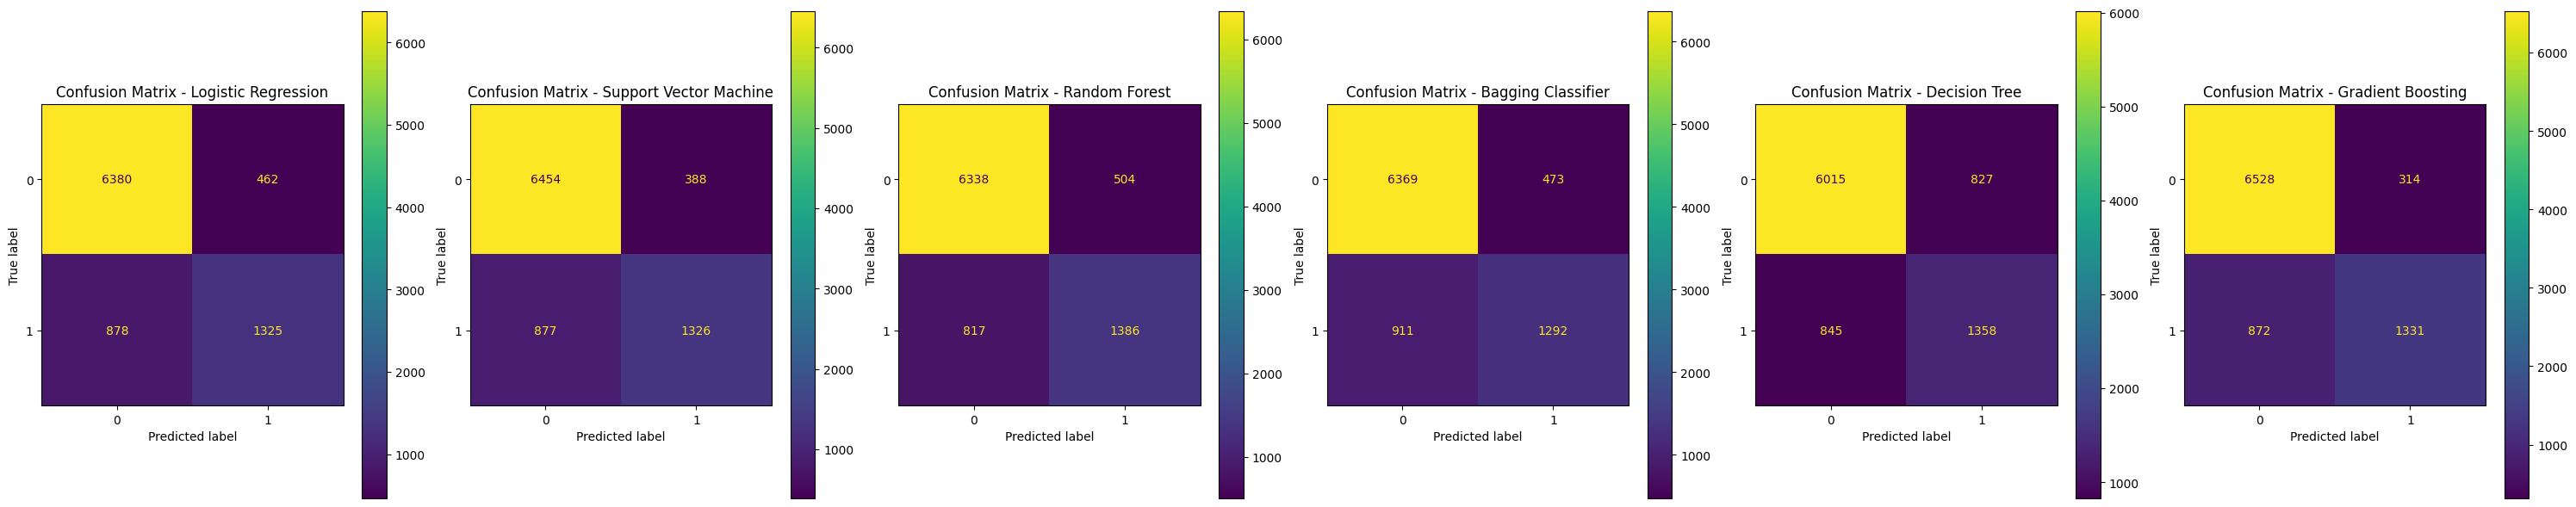

In [53]:
plot_confusion_matrix_for_models(predictions)

### Summary
In this tutorial, we learnt how to develop and evaluate different models for the imbalanced adult income classification dataset.

Specifically, we learned:

How to load and and prepare the dataset for model development using a wrangle function
How to preprocess categorical data (using OneHotEncoder) and numerical data (using StandardScalar)
How to build, evaluate and compare the performance of different modelson the dataset.
How to use python functions to build and evaluate models

You can find the project Notebook in my github repository [here](https://github.com/osareniho-oni/classification_models)

### Conclusion
We can see from the Accuracy scores, confusion matrix and the ROC curves that different models perform closely but differently on the chosen dataset.

We can further improve the performance of each model by tuning their hyperparameters but that is not the focus in this tutorial.